### 참고

- 넷플릭스
    - 슬로건 : 모든것이 추천이다
    - https://netflixtechblog.com/55838468f429
    - 넷플릭스의 추천 알고리즘 구현에 대한 기술 블로그 공개

# 1. 연구 목표

- 사용자 평점 데이터를 기반으로 사용자를 특정을 예측하여 추천 시스템을 구축한다
- 실제 OTT나 쇼핑몰에서 회원가입시 추천 알고리즘으로 사용된다
- 회귀 처리, 회귀 평가, 추천시스템에 대한 이해
- FastFM(thrid party 알고리즘 사용-> 인수분해머신 기능 지원)
    - 윈도우에서 컴파일 후 설치가 불가하므로, 리눅스에 설치하여 개발을 진행

# 2. 데이터 수집, 확보

- ml-100k.zip 파일 제공
- 영화 정보 데이터
    - 고객 정보 : u.user
    - 영화 정보
    
    - 평점 정보

In [1]:
import pandas as pd

In [2]:
# u.user 라는 데이터에 컬럼이 없다보니 첫번째 데이터가 컬럼이 되었다.
# 이를 예방하기 위해서 컬럼을 지정해준다.
cols =['uid','age','m','job','zip_code']
users = pd.read_csv('./table/ml-100k/u.user', sep='|', names=cols)
users.head(2)

,uid,age,m,job,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


In [3]:
users.tail


(2)

2

In [4]:
# 고객 943명의 데이터
users.shape

(943, 5)

In [5]:
# 영화 정보 로드
m_cols =['mid','title','release_date','video_release_date','imbd_url']
# 영어권이면 utf-8에서 오류나면 latin1으로 사용
# 원본 데이터의 컬럼이 많은데 부분만 쓰고싶다면 usecols 를 적용
movies = pd.read_csv('./table/ml-100k/u.item', sep='|', encoding='latin1', names=m_cols, usecols=range(5))
movies.head(2)

,mid,title,release_date,video_release_date,imbd_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...


In [6]:
movies.shape

(1682, 5)

In [7]:
movies.tail(2)

,mid,title,release_date,video_release_date,imbd_url
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...


In [8]:
# 평점 정보 로드 : u.data
r_cols =['uid','mid','rating','unix_timestamp']
ratings = pd.read_csv('./table/ml-100k/u.data', sep='\t', names=r_cols)
ratings.head(2)

,uid,mid,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742


In [9]:
ratings.tail(2)

,uid,mid,rating,unix_timestamp
99998,13,225,2,882399156
99999,12,203,3,879959583


In [10]:
ratings.shape

(100000, 4)

In [11]:
ratings.unix_timestamp

0        881250949
1        891717742
2        878887116
3        880606923
4        886397596
           ...    
99995    880175444
99996    879795543
99997    874795795
99998    882399156
99999    879959583
Name: unix_timestamp, Length: 100000, dtype: int64

In [12]:
# unix_timestamp 는 1970년 1월 1일 00시 00분 00초 부터 현재까지 경과된 시간
# 그래서 현재 시간, 특정시간을 특정하기가 어렵다 -> 해석이 어렵다 -> 시간형식을 변경한다
ratings['date'] = pd.to_datetime( ratings.unix_timestamp, unit='s' )

In [13]:
ratings.head(2)

,uid,mid,rating,unix_timestamp,date
0,196,242,3,881250949,1997-12-04 15:55:49
1,186,302,3,891717742,1998-04-04 19:22:22


In [14]:
# 3. 데이터 준비, 품질향상, 전처리

In [15]:
# 4. 데이터분석 (통계,시각화)

In [23]:
# 평점과 영화 데이터 합치기
# 합친 결과 => (10000,9)
# merge를 수행할 때 중복되는 컬럼은 생략하면 알아서 찾아서 수행된다
# 단, 컬럼이 2개 이상이면 검토가 필요하다
movies_ratings = pd.merge(movies, ratings)

In [24]:
movies_ratings.shape

(100000, 9)

In [25]:
movies_ratings.head(3)

,mid,title,release_date,video_release_date,imbd_url,uid,rating,unix_timestamp,date
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088,1997-09-27 04:21:28
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,148,4,877019411,1997-10-16 16:30:11


In [29]:
# movies_ratings, users  합치기
movies_lens = pd.merge(movies_ratings , users)

In [30]:
movies_lens.shape

(100000, 13)

In [31]:
movies_lens.head(10)

,mid,title,release_date,video_release_date,imbd_url,uid,rating,unix_timestamp,date,age,m,job,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,1998-02-17 17:28:52,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,1998-02-17 17:51:30,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,1998-02-17 18:20:08,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,1998-02-17 18:07:27,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,1998-02-17 17:31:36,60,M,retired,95076
5,9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,308,4,887737194,1998-02-17 17:39:54,60,M,retired,95076
6,11,Seven (Se7en) (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Se7en%20(1995),308,5,887737837,1998-02-17 17:50:37,60,M,retired,95076
7,12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,308,5,887737243,1998-02-17 17:40:43,60,M,retired,95076
8,15,Mr. Holland's Opus (1995),29-Jan-1996,NaN,http://us.imdb.com/M/title-exact?Mr.%20Holland...,308,3,887739426,1998-02-17 18:17:06,60,M,retired,95076
9,17,From Dusk Till Dawn (1996),05-Feb-1996,NaN,http://us.imdb.com/M/title-exact?From%20Dusk%2...,308,4,887739056,1998-02-17 18:10:56,60,M,retired,95076


- 데이터를 모두 병합하였다. 평점이나 회원을 중심으로 중복적인 데이터가 많다
- 데이터가 적으면 크게 문제 없으나, 크면 메모리를 많이 사용할 수도 있다(검토)

In [34]:
# 평가를 가장 많이 받은 영화 상위 10개를 출력하시오
# mid 나 title 둘 다 사용이 가능하나 결과를 이해하기 위해서 title 사용
movies_lens.title.value_counts()[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [36]:
# 평점을 받은 횟수가 적은 경우, 우현히 평점이 좋을 수도 있다.
# 따라서 데이터를 조정할때 특정횟수(임계치) 이상 평가한 작품만 고려한다.
movies_lens.title.value_counts()[-10:]

Wedding Bell Blues (1996)      1
Mad Dog Time (1996)            1
Office Killer (1997)           1
T-Men (1947)                   1
Window to Paris (1994)         1
Love Is All There Is (1996)    1
Normal Life (1996)             1
You So Crazy (1994)            1
New Age, The (1994)            1
MURDER and murder (1996)       1
Name: title, dtype: int64

- 제목 기준으로 데이터를 분류
- 평가의 개수, 평균평점이 들어가있는 DF 
- 인덱스 : title, 컬럼 : 개수, 평균평점 <= 만드는 과정에서 컬럼의 레벨이 1이상이 되도 관계없음

In [38]:
import numpy as np

In [40]:
# groupby(컬럼) : 해당 컬럼이 인덱스로 이동
# agg ({컬럼 : [값 처리 함수..]}) : 컬럼에 처리함수 개수대로 설정되서 값이 자동 처리
movie_state = movies_lens.groupby('title').agg( {'rating':[np.size, np.mean]} )
movie_state.head(2)

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000

In [ ]:
# 이 케이스에서는 피벗의 표현이 더 복잡할 수 있어서 배제하고 groupby 사용
# movie_lens.pivot_table()

- 평점을 받은 개수가 1개인 경우, 소수의 평가를 받은 영화
- 평균의 수가 적으면 잡음의 개입이 여지가 많다
- 100건 기준으로 100개 이상만 대상으로 처리 (임계값)

In [44]:
# 차후 변경함으로써 성능을 다르게 낼 수 있다
limit_std_value = 100
condition       = movie_state['rating']['size'] >= limit_std_value
condition[:2]

title
'Til There Was You (1997)    False
1-900 (1994)                 False
Name: size, dtype: bool

In [45]:
# 불리언 인덱싱
movie_state[condition]

rating          
                                               size      mean
title                                                        
101 Dalmatians (1996)                           109  2.908257
12 Angry Men (1957)                             125  4.344000
2001: A Space Odyssey (1968)                    259  3.969112
Absolute Power (1997)                           127  3.370079
Abyss, The (1989)                               151  3.589404
...                                             ...       ...
Willy Wonka and the Chocolate Factory (1971)    326  3.631902
Wizard of Oz, The (1939)                        246  4.077236
Wrong Trousers, The (1993)                      118  4.466102
Young Frankenstein (1974)                       200  3.945000
Young Guns (1988)                               101  3.207921

[338 rows x 2 columns]

In [48]:
# 정렬 -> 평균 내림차순으로 정렬하여 상위 5개만 출력
# 컬럼 레벨이 n 차 인 경우 정렬하는방법
tmp = movie_state[condition].sort_values( by = [ ('rating', 'mean' ) ] , ascending = False )
tmp.head(5)

rating          
                                   size      mean
title                                            
Close Shave, A (1995)               112  4.491071
Schindler's List (1993)             298  4.466443
Wrong Trousers, The (1993)          118  4.466102
Casablanca (1942)                   243  4.456790
Shawshank Redemption, The (1994)    283  4.445230

In [49]:
# 영화 1682개 중에서 임계값을 통과한 대상은 338개이다
# 이를 통해서 평점을 적게 받은 영화의 통계적인 추정도 가능하다

tmp.shape, movies.shape

((338, 2), (1682, 5))

In [50]:
# 간단한 시각화
# 영화별 평점의 개수 : x 축
# 평가 횟수 : y 축
from matplotlib import pyplot as plt

%matplotlib inline

'\nStar Wars (1977)                 583\n스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 이 영화만 평가한 유저도 다수 존재한다.\n(현 데이터에서는 최저 평가회수가 사용자당 20)\n'

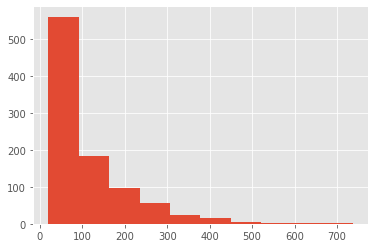

In [54]:
# 히스토그램
plt.style.use('ggplot')
movies_lens.groupby('uid').size().sort_values(ascending = False).hist()
# 사용자의 평가 횟수에 대한 성향
# 빈도가 점점 낮아진다 -> 오른쪽으로 길게 꼬리를 늘어트리는 모양 -> 롱테일 분포
# '지프의법칙' 을 따른 굴곡 모양이다
# 영화의 평가가 많으면 그 사용자들 중에는 1회성 평가 횟수도 많다
"""
Star Wars (1977)                 583
스타워즈 1977년 작품에 평가가 583회가 수행되었는데, 이중에는 이 영화만 평가한 유저도 다수 존재한다.
(현 데이터에서는 최저 평가회수가 사용자당 20)
"""

In [52]:
movies_lens.groupby('uid').size().sort_values(ascending = False)

uid
405    737
655    685
13     636
450    540
276    518
      ... 
36      20
34      20
685     20
441     20
202     20
Length: 943, dtype: int64

In [56]:
# 사용자별 평가 횟수, 평균
user_state = movies_lens.groupby('uid').agg( { 'rating':[np.size , np.mean] } )
user_state.head()

rating          
      size      mean
uid                 
1      272  3.610294
2       62  3.709677
3       54  2.796296
4       24  4.333333
5      175  2.874286

In [57]:
user_state.describe()
# 최저값: 1.49 최대 :4.67 25~75% 지점 : 3점대로 몰려있다.
# 평균 : 3.58 => 어떤 영화든지 일반적으로 3점 이상은 받는다 라고 해석할 수 있다
# 3점 이하는 영화 자체에 문제가 있어 보인다

rating            
             size        mean
count  943.000000  943.000000
mean   106.044539    3.588191
std    100.931743    0.445233
min     20.000000    1.491954
25%     33.000000    3.323054
50%     65.000000    3.620690
75%    148.000000    3.869565
max    737.000000    4.869565

### 5. 예측모델구축(머신러닝기반)

- 알고리즘 => 인수분해 머신기능을 제공하는 FastFM 이라는 모듈 사용
- FastFM
    - C++로 만들어진 libFM 이라는 알고리즘
    - libFM을 python으로 구성한 것이 FastFM
    - 기능
        - 행렬 인수 분해라는 기능을 일반화하여서 제공 -> 차원축소기법
        - 범주형 변수를 파생변수로 변환하여 범주간의 상호 작용성을 계산
        - 특징 간 영향을 주고 받은 상화 작용 개념을 계산

- FastFM 제공 알고리즘
    - ALS : 교대 최소 제곱법
        - 장점 : 예측시간 빠름 , SGD에 비해 하이퍼파라미터가 적다.
        - 단점 : 규제처리가 필요
    - SGD : 확률적 경사 하강법
        - 장점 : 예측시간 빠름 , 빅데이터를 빠르게 처리, 학습할 수 있다
        - 단점 : 하이퍼파라미터가 많다. 규제처리가 필요    
    - MCMC : 마르코프 연쇄 몬테카를로
        - 장점 : 하이퍼파라미터가 작다.
        - 단점 : 학습 시간이 느리다    

In [ ]:
# 아마존 EC2 서버에 접속하였다.
# febric3를 이용하여 이하 과정을 자동화 할 수 있다

# 리눅스 상에서 루트 권한 획득
ubuntu : $ sudo su

# 리눅스의 현재 설치된 패키지등을 최신으로 업그레이드
root : $ apt-get update && apt-get -y upgrade

# 파이썬 확인
$ python3 -V
# 패키지 설치 (파이썬이 설치 되어 있으면 파이썬 부분은 제외)
$ apt-get -y install python3-dev python3-pip git nano wget unzip libopenblas-dev
# 파이썬이 있으면 이하만 설치
$ apt-get -y install python3-pip git nano wget unzip libopenblas-dev

# fastFM 소스 다운로드
$ git clone --recursive https://github.com/ibayer/fastFM.git
$ cd fastFM

# 컴파일을 수행하기 전에 python 모듈 설치
# 내용확인
$ cat requirements.txt
$ pip3 install -r ./requirements.txt

# 컴파일 -> 마지막 부분에 error가 보여도 무시
$ PYTHON=python3 make

# fastFM 설치
$ pip3 install . 

# 확인
$ python3
>>> from fastFM import als
>>> exit()

# 개발에 필요한 패키지 설치
$ pip3 install pandas matplotlib jupyter

# 옵션(삭제)
$ rm -r -f dev

# root 계정 오프
$ exit

# 작업폴더 생성
$ cd ..
$ mkdir dev && cd dev

# 주피터 가동 포트번호 기본 8888
$ jupyter notebook --ip=0.0.0.0 --port=8888 --allow-root --no-browser

http://ip-172-31-34-89:8888/?token=09bf078e200b32ec34b8921392c59716eeb2c44c90e7f1da
http://52.78.7.28:8888/?token=594bfaf44f1266acffb02a0b1495423fc4a7e0edcf4adfc4 
http://52.78.7.28:8888/?token=b9d4cf499acfaab0c672ff226b189a37d877b7febe4789c1


- 여기서부터는 리눅스에서 운용되므로 현 파일은 종료
    - 단 리눅스 서버에서 주피터를 새로 가동했으면 토큰은 신규로 입력해야한다
    
<a href = 'http://52.78.7.28:8888'> 이동</a>

In [17]:
# 5. 예측모델구축(머신러닝기반)

In [18]:
# 6. 시스템 통합 (서비스에 반영, OTT, 쇼핑몰 등등)